In [1]:
"""
@author: Michael
@version: 2021-11-25
"""
import os
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn

In [2]:

# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "==========" * 1 + "%s" % nowtime)


# mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"



In [3]:
#样本数量
n = 400

# 生成测试用数据集
X = 10 * torch.rand([n, 2]) - 5.0  #torch.rand是均匀分布
w0 = torch.tensor([[2.0], [-3.0]])
b0 = torch.tensor([[10.0]])
Y = X @ w0 + b0 + torch.normal(0, 0.01, size=[n, 1])  # @表示矩阵乘法,增加正态扰动


In [4]:
X[:10], Y[:10]

(tensor([[ 4.0495,  1.3501],
         [-0.6617, -2.6846],
         [ 4.1748,  2.6931],
         [ 0.6751,  2.4211],
         [-1.5141,  1.7045],
         [-2.6857,  1.2214],
         [ 4.9621, -1.8865],
         [ 3.0051, -2.1414],
         [-1.9247,  2.6898],
         [ 2.9859,  3.3807]]),
 tensor([[14.0459],
         [16.7268],
         [10.2624],
         [ 4.0682],
         [ 1.8582],
         [ 0.9745],
         [25.5961],
         [22.4370],
         [-1.9092],
         [ 5.8278]]))

<Figure size 432x288 with 0 Axes>

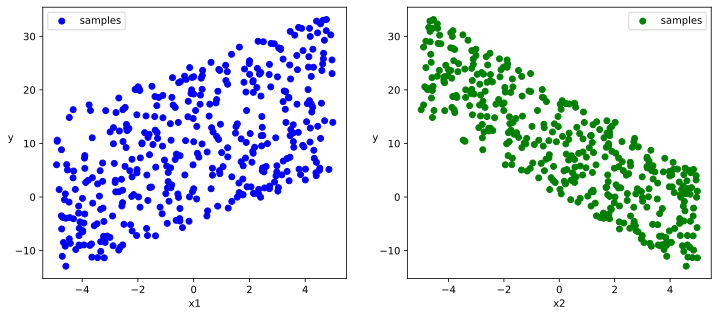

In [5]:
%config InlineBackend.figure_format = 'svg'
plt.clf()
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0].numpy(), Y[:, 0].numpy(), c="b", label="samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y", rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1].numpy(), Y[:, 0].numpy(), c="g", label="samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y", rotation=0)
plt.show()


In [6]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, indexs), labels.index_select(0, indexs)


# 测试数据管道效果   
batch_size = 8
(features, labels) = next(data_iter(X, Y, batch_size))
print(features)
print(labels)


tensor([[ 2.0566,  4.0795],
        [-4.3228, -4.9876],
        [ 2.3335,  4.4158],
        [-1.3694,  4.8344],
        [ 4.6599, -2.5036],
        [ 1.0042,  1.2337],
        [-2.5764,  2.1725],
        [ 0.2435, -2.8418]])
tensor([[ 1.8889],
        [16.3066],
        [ 1.4296],
        [-7.2534],
        [26.8366],
        [ 8.2924],
        [-1.6817],
        [19.0265]])


In [7]:
# 定义模型
class LinearRegression: 
    
    def __init__(self):
        self.w = torch.randn_like(w0,requires_grad=True)
        self.b = torch.zeros_like(b0,requires_grad=True)
        
    #正向传播
    def forward(self,x): 
        return x@self.w + self.b

    # 损失函数
    def loss_func(self,y_pred,y_true):  
        return torch.mean((y_pred - y_true)**2/2)
    
    def parameters(self):
        return [self.w, self.b]

def sgd(params, lr=0.01):
    # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录 
    with torch.no_grad():
        # 梯度下降法更新参数
        for param in params:
            param -= lr * param.grad
            # 梯度清零
            param.grad.zero_()

model = LinearRegression()



In [8]:
def train_step(model, features, labels):
    
    predictions = model.forward(features)
    loss = model.loss_func(predictions,labels)
        
    # 反向传播求梯度
    loss.backward()
    
    # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录 
    # with torch.no_grad():
    #     # 梯度下降法更新参数
    #     model.w -= 0.001*model.w.grad
    #     model.b -= 0.001*model.b.grad

    #     # 梯度清零
    #     model.w.grad.zero_()
    #     model.b.grad.zero_()
    sgd(model.parameters(), lr=0.01)
    return loss
 


In [9]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)



tensor(84.2937, grad_fn=<MeanBackward0>)

In [10]:
def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        for features, labels in data_iter(X, Y, 10):
            loss = train_step(model, features, labels)

        if epoch % 200 == 0:
            printbar()
            print("epoch =", epoch, "loss = ", loss.item())
            print("model.w =", model.w.data)
            print("model.b =", model.b.data)


train_model(model, epochs=1000)



==========2022-03-13 18:56:10
epoch = 200 loss =  5.069177859695628e-05
model.w = tensor([[ 2.0002],
        [-3.0000]])
model.b = tensor([[10.0002]])

==========2022-03-13 18:56:13
epoch = 400 loss =  3.92283036489971e-05
model.w = tensor([[ 2.0000],
        [-2.9997]])
model.b = tensor([[10.0002]])

==========2022-03-13 18:56:15
epoch = 600 loss =  7.386881770798936e-05
model.w = tensor([[ 2.0001],
        [-2.9998]])
model.b = tensor([[10.0002]])

==========2022-03-13 18:56:18
epoch = 800 loss =  5.677638546330854e-05
model.w = tensor([[ 2.0002],
        [-2.9995]])
model.b = tensor([[10.0003]])

==========2022-03-13 18:56:21
epoch = 1000 loss =  7.118915527826175e-05
model.w = tensor([[ 2.0002],
        [-2.9997]])
model.b = tensor([[10.0002]])


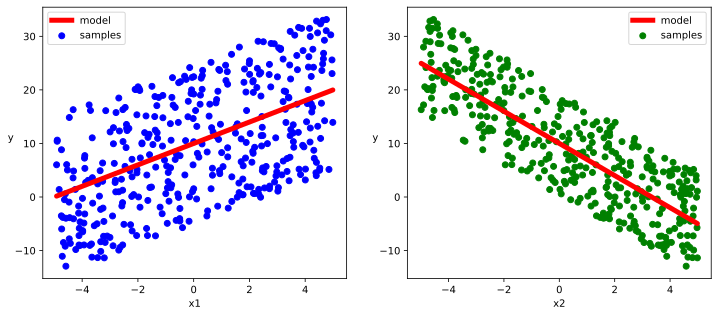

In [11]:
plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.plot(X[:,0].numpy(),(model.w[0].data*X[:,0]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.plot(X[:,1].numpy(),(model.w[1].data*X[:,1]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()
